In [1]:
from astropy.table import QTable
import numpy as np
from pathlib import Path

ImportError: attempted relative import with no known parent package

# Utilitaire

In [360]:
class CTLearnModelManager():

    def __init__(self, model_nickname,
    notes,
    model_dir,
    reco,
    telescope_names,
    telescopes_indices,
    training_gamma_dirs,
    training_proton_dirs,
    training_gamma_zenith_distances,
    training_gamma_azimuths,
    training_proton_zenith_distances,
    training_proton_azimuths):
        
        self.model_nickname = model_nickname
        self.notes = notes
        self.model_dir = f"{model_dir}/{model_nickname}"
        self.reco = reco
        self.telescope_names = telescope_names
        self.telescopes_indices = telescopes_indices
        self.training_gamma_dirs = training_gamma_dirs
        self.training_proton_dirs = training_proton_dirs
        self.training_gamma_zenith_distances = training_gamma_zenith_distances
        self.training_gamma_azimuths = training_gamma_azimuths
        self.training_proton_zenith_distances = training_proton_zenith_distances
        self.training_proton_azimuths = training_proton_azimuths
        self.columns = ['model_index', 
           'model_nickname', 'model_name', 
           'model_dir',
           'reco', 
           'telescope_names', 'telescopes_indices', 
           'training_gamma_dirs', 'training_proton_dirs', 
           'training_gamma_zenith_distances', 'training_gamma_azimuths', 
           'training_proton_zenith_distances', 'training_proton_azimuths', 
           'notes', 
           'zd_range', 'az_range',
           'testing_gamma_dirs', 'testing_proton_dirs',
           'testing_gamma_zenith_distances', 'testing_gamma_azimuths',
           'testing_proton_zenith_distances', 'testing_proton_azimuths',]
        self.stereo = True if len(self.telescopes_indices) > 1 else False
        if self.reco == 'type' and (len(self.training_proton_dirs) == 0 or len(self.training_gamma_dirs) == 0):
            raise ValueError("For reco type, training_proton_dirs and training_gamma_dirs are required")
        # if self.reco == 'type' & (len(self.training_proton_dirs) == 0 or len(self.training_gamma_dirs) == 0):
        #     raise ValueError("For reco type, training_proton_dirs and training_gamma_dirs are required")
        # Check that all gamma related lists are the same length
        gamma_lengths = [len(self.training_gamma_dirs), len(self.training_gamma_zenith_distances), len(self.training_gamma_azimuths)]
        if len(set(gamma_lengths)) != 1:
            raise ValueError("All gamma related lists must be the same length")

        # Check that all proton related lists are the same length
        proton_lengths = [len(self.training_proton_dirs), len(self.training_proton_zenith_distances), len(self.training_proton_azimuths)]
        if len(set(proton_lengths)) != 1:
            raise ValueError("All proton related lists must be the same length")
        
        # Model parameters
        self.zd_range = [min(self.training_gamma_zenith_distances), max(self.training_gamma_zenith_distances)]
        self.az_range = [min(self.training_gamma_azimuths), max(self.training_gamma_azimuths)]
        self.model_name = f"{self.reco}_TEL{'_'.join(map(str, self.telescopes_indices))}_ZD{'_'.join(map(str, self.training_gamma_zenith_distances))}_Az{'_'.join(map(str, self.training_gamma_azimuths))}"
        print(f"🧠 Model name: {self.model_name}")
        
        
    def save_to_index(self, MODEL_INDEX_FILE):
        try:
            models_table = QTable.read(MODEL_INDEX_FILE)
            model_index = models_table['model_index'][-1] + 1
        except:
            models_table = QTable(names=self.columns,  
                                #   units=[None, None, None, None, None, None, None, None, 'deg', 'deg', 'deg', 'deg', None, 'deg', 'deg', None, None, 'deg', 'deg', 'deg', 'deg'],
                                dtype=[int,
                                        str, str, 
                                        str, str,
                                        list, list, 
                                        list, list, 
                                        list, list, 
                                        list, list, 
                                        str, 
                                        list, list,
                                        list, list,
                                        list, list,
                                        list, list])
            print(f"Model index did not exist, will create {MODEL_INDEX_FILE}")
            model_index = 0
        # if not Path(self.model_dir).exists():
        #     Path(self.model_dir).mkdir()
        #     print(f"Model directory {self.model_dir} created")
        if (self.model_nickname not in models_table['model_nickname']):
            models_table.add_row([model_index, 
                                self.model_nickname, self.model_name, 
                                self.model_dir,
                                self.reco, self.telescope_names, self.telescopes_indices, 
                                self.training_gamma_dirs, self.training_proton_dirs, 
                                self.training_gamma_zenith_distances, self.training_gamma_azimuths, 
                                self.training_proton_zenith_distances, self.training_proton_azimuths, 
                                self.notes, 
                                self.zd_range, self.az_range, 
                                [], [], 
                                [], [], 
                                [], []])
            models_table.write(MODEL_INDEX_FILE, format='ascii.ecsv', serialize_method='data_mask', overwrite=True)
            print(f"✅ Model nickname {self.model_nickname} added to table")
        else:
            print(f"❌ Model nickname {self.model_nickname} already in table")
        
        
    def launch_training(self, n_epochs=15):
        import glob
        import os
        models_dir = np.sort(glob.glob(f"{self.model_dir}*"))
        load_model = False
        if len(models_dir) > 0 :
            last_model_dir = Path(models_dir[-1])
            size = sum(f.stat().st_size for f in last_model_dir.glob('**/*') if f.is_file())
            model_version = int(models_dir[-1].split("_v")[-1])
            if size > 1e6:
                model_version += 1
                print(f"➡️ Model already exists: will continue training and create \n📁 {self.model_nickname}_v{model_version}")
                save_best_validation_only = True
                model_dir = f"{self.model_dir}_v{model_version}/"
                model_to_load = f"{self.model_dir}_v{model_version - 1}/ctlearn_model.cpk/"
                load_model = True
                os.system(f"mkdir -p {model_dir}")
            else :
                model_dir = f"{self.model_dir}_v{model_version}/"
                if model_version > 0:
                    model_to_load = f"{self.model_dir}_v{model_version - 1}/ctlearn_model.cpk/"
                    load_model = True
                    print(f"➡️ Model already exists: will continue training and create \n📁 {self.model_nickname}_v{model_version}")
                    save_best_validation_only = True
                else:
                    print(f"🆕 Model does not exist: will create \n📁 {self.model_nickname}_v{model_version}")
                    save_best_validation_only = False
        else:
            model_version = 0
            print(f"🆕 Model does not exist: will create \n📁 {self.model_nickname}_v{model_version}")
            model_dir = f"{self.model_dir}_v{model_version}/"
            os.system(f"mkdir -p {model_dir}")
            save_best_validation_only = False

        load_model_string = f"--TrainCTLearnModel.model_type=LoadedModel --LoadedModel.load_model_from={model_to_load} " if load_model else ""
        background_string = f"--background {self.training_proton_dirs[0]} " if self.reco == 'type' else "" #FIXM loop over protons/gamma dirs and add patterns
        signal_patterns = ""
        background_patterns = ""
        # for ze, az in zip(zes, azs):
        #     signal_patterns += f'--pattern-signal "gamma_theta_{ze:.3f}_az_{az:.3f}_runs*.dl1.h5" '
        # if reco == 'type':
        #     for ze, az in zip(zes_protons, azs_protons):
        #         background_patterns += f'--pattern-background "proton_theta_{ze:.3f}_az_{az:.3f}_runs*.dl1.h5" '

        stereo_mode = 'stereo' if self.stereo else "mono"
        stack_telescope_images = 'true' if self.stereo else 'false'
        min_telescopes = 2 if self.stereo else 1
        allowed_tels = '_'.join(map(str, self.telescopes_indices)) if self.stereo else int(self.telescopes_indices[0])
        cmd = f"ctlearn-train-model {load_model_string}\
            --signal {self.training_gamma_dirs[0]} {signal_patterns}\
            {background_string}{background_patterns}\
            --reco {self.reco} \
            --output {model_dir} \
            --DLImageReader.channels=cleaned_image \
            --DLImageReader.channels=cleaned_relative_peak_time \
            --TrainCTLearnModel.n_epochs={n_epochs} \
            --verbose \
            --TrainCTLearnModel.save_best_validation_only=True\
            --overwrite \
            --DLImageReader.mode={stereo_mode} \
            --TrainCTLearnModel.stack_telescope_images={stack_telescope_images}\
            --DLImageReader.min_telescopes={min_telescopes}"# \
            #--DLImageReader.allowed_tels={allowed_tels}"
        print(cmd)
        !{cmd}
    
    # def launch_testing(self):
    #     # self.
    #     pass
    
    # def produce_irfs(self):
    #     pass
    
    def plot_loss(self):
        import matplotlib.pyplot as plt
        import pandas as pd
        import glob
        training_log = np.sort(glob.glob(f"{self.model_dir}_v*/training_log.csv"))[-1]
        if Path(training_log).exists():
            df = pd.read_csv(training_log)
            plt.plot(df['epoch'], df['loss'], label=f"Training")
            plt.plot(df['epoch'], df['val_loss'], label=f"Testing", ls='--')
            plt.title(f"{self.reco} training")
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()
            plt.show()
        else:
            print(f"Model has not yet been trained.")

# 🧠 Create new CTLearnModelManager
CTLearnModelManager is an object that allows you to setup, train, test and benchmark a CTLearn model

In [361]:
MODEL_INDEX_FILE = "/home/blacave/CTLearn/Software/CTLearn-Manager/ctearn_models_index.ecsv"

In [362]:
# General parameters
model_parameters = {
    'model_nickname' : "direction_20deg",
    'model_dir' : "/home/blacave/CTLearn/Data/CTLearn_Models_SST1M/",
    'notes' : "Stereo model for 20deg zenith distance",
    'reco' : 'energy', #["energy", "direction", "type"]
    'telescope_names' : ['SST1M_1', 'SST1M_2'],
    'telescopes_indices' : [1, 2],
    'training_gamma_dirs' : ['/home/blacave/CTLearn/Data/DL1/SST1M/MC/Gamma_diffuse/20deg/merged/'],
    'training_proton_dirs' : ['/home/blacave/CTLearn/Data/DL1/SST1M/MC/Proton/20deg/merged/'],
    'training_gamma_zenith_distances' : [20],
    'training_gamma_azimuths' : [0],
    'training_proton_zenith_distances' : [20],
    'training_proton_azimuths' : [0],
}
new_model = CTLearnModelManager(**model_parameters)
new_model.save_to_index(MODEL_INDEX_FILE)

🧠 Model name: energy_TEL1_2_ZD20_Az0
❌ Model nickname direction_20deg already in table


In [ ]:
new_model.launch_training(n_epochs=15)

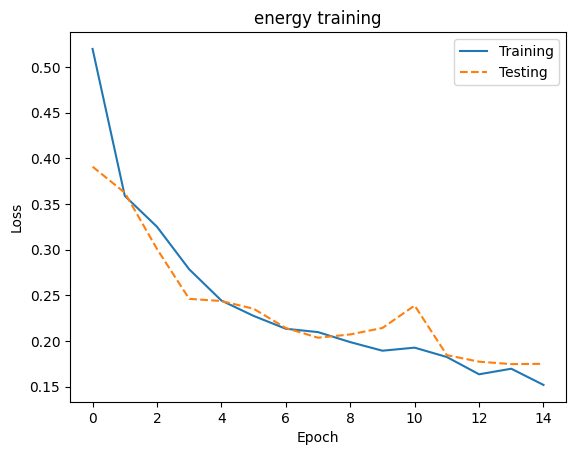

In [363]:
new_model.plot_loss()